In [1]:
%matplotlib inline

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
params = {
    'batch_size':  16,
    'num_workers': 2,
    'device':   'cpu',
    'num_epochs': 4,
    'learning_rate': 0.0001,
    'weight_decay': 5e-4,
}
transform = transforms.ToTensor()
## Train
trainset = torchvision.datasets.MNIST('../data', 
                                      train=True, 
                                      download=True, 
                                      transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=params['batch_size'], 
                                          shuffle=True, 
                                          num_workers=params['num_workers'])
### Test 
testset = torchvision.datasets.MNIST('../data', 
                                     train=False, 
                                     download=True, 
                                     transform=transform)
testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=params['batch_size'], 
                                         shuffle=False, 
                                         num_workers=params['num_workers'])

In [3]:
trainloader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ../data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [4]:
testloader.dataset

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ../data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [5]:
def show_batch(batch):
    im = torchvision.utils.make_grid(batch)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

tensor([2, 1, 1, 3, 8, 0, 8, 0, 5, 0, 9, 4, 0, 7, 6, 3])


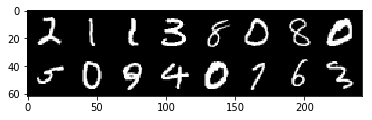

In [6]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(labels)
show_batch(images)

In [7]:
## Simple MLP
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_labels):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_labels)

    def forward(self, x):
        h_relu = F.relu(self.linear1(x.view(params['batch_size'], -1)))
        y_pred = self.linear2(h_relu)
        return y_pred

In [8]:
NUM_LABELS = len(list(set(trainloader.dataset.train_labels.numpy())))
INPUT_SIZE = trainloader.dataset.train_data[0].flatten().shape[0]
HIDDEN_SIZE = 32
model = MLP(INPUT_SIZE, HIDDEN_SIZE, NUM_LABELS)
model

MLP(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [9]:
def train(model, trainloader, criterion, optimizer, n_epochs=10):
    for t in range(n_epochs):
        for i, data in enumerate(trainloader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels) 
            loss.backward() 
            optimizer.step()

            if not i % 2000:
                print("    --> EPOCH {}, ITER {}, LOSS {}".format(t, i, loss.data.numpy()))

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
train(model, trainloader, criterion, optimizer, n_epochs = params['num_epochs'])

    --> EPOCH 0, ITER 0, LOSS 2.276787757873535
    --> EPOCH 0, ITER 2000, LOSS 0.3918612003326416
    --> EPOCH 1, ITER 0, LOSS 0.3521057069301605
    --> EPOCH 1, ITER 2000, LOSS 0.41213178634643555
    --> EPOCH 2, ITER 0, LOSS 0.3926185667514801
    --> EPOCH 2, ITER 2000, LOSS 0.11070802807807922
    --> EPOCH 3, ITER 0, LOSS 0.3200305104255676
    --> EPOCH 3, ITER 2000, LOSS 0.5517382025718689


In [11]:
def predict(model, images):
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    return predicted

LABELS: [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5]
PREDICTION:  [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5]


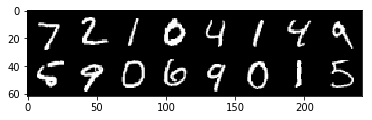

In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()
print("LABELS: {}".format(labels.numpy()))
print('PREDICTION: ', predict(model, images).numpy())
show_batch(images)

In [13]:
def test(model, testloader):
    correct = 0
    for data in testloader:
        inputs, labels = data
        pred = predict(model, inputs)
        correct += (pred == labels).sum()
    return 100 * correct / len(testset)

In [14]:
print('ACCURACY: {}%'.format(test(model, testloader).numpy()))

ACCURACY: 92%


## Using Weight Pruning

In [15]:
params = {
    'pruning_perc': 85.,
    'batch_size': 16, 
    'test_batch_size': 100,
    'num_epochs': 4,
    'learning_rate': 0.001,
    'weight_decay': 5e-4,
}

In [16]:
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super(MaskedLinear, self).__init__(in_features, out_features, bias)
        self.mask_flag = False
    
    def set_mask(self, mask):
        self.register_buffer('mask', mask)
        mask_var = self.get_mask()
        self.weight.data = self.weight.data*mask_var.data
        self.mask_flag = True
    
    def get_mask(self):
        return self.mask.clone().detach().requires_grad_(False)
    
    def set_sign(self, mask):
        self.register_buffer('mask', mask)
        mask_var = self.get_mask()
        self.weight.data = self.weight.data*mask_var.data
        self.mask_flag = True
    
    def forward(self, x):
        if self.mask_flag == True:
            mask_var = self.get_mask()
            weight = self.weight * mask_var
            return F.linear(x, weight, self.bias)
        else:
            return F.linear(x, self.weight, self.bias)

In [17]:
## Simple MLP
class MLP_weight_prunning(nn.Module):
    def __init__(self, input_size, hidden_size, num_labels):
        super(MLP_weight_prunning, self).__init__()
        self.linear1 = MaskedLinear(input_size, hidden_size)
        self.linear2 = MaskedLinear(hidden_size, num_labels)

    def forward(self, x):
        h_relu = F.relu(self.linear1(x.view(params['batch_size'], -1)))
        y_pred = self.linear2(h_relu)
        return y_pred
    
    def set_masks(self, masks):
        self.linear1.set_mask(masks[0])
        self.linear2.set_mask(masks[1])

    def set_signs(self, signs):
        sign_1 = torch.FloatTensor(signs[0]).view(self.linear1.weight.data.shape[0],-1)
        sign_2 = torch.FloatTensor(signs[1]).view(self.linear2.weight.data.shape[0],-1)
        self.linear1.weight.data = torch.mul(self.linear1.weight.data.abs(),sign_1)
        self.linear2.weight.data = torch.mul(self.linear2.weight.data.abs(),sign_2)

In [18]:
NUM_LABELS = len(list(set(trainloader.dataset.train_labels.numpy())))
INPUT_SIZE = trainloader.dataset.train_data[0].flatten().shape[0]
HIDDEN_SIZE = 32

model_2 = MLP_weight_prunning(INPUT_SIZE, HIDDEN_SIZE, NUM_LABELS)
print('ACCURACY: {}%'.format(test(model_2, testloader).numpy()))
model_2

ACCURACY: 13%


MLP_weight_prunning(
  (linear1): MaskedLinear(in_features=784, out_features=32, bias=True)
  (linear2): MaskedLinear(in_features=32, out_features=10, bias=True)
)

In [19]:
def weight_prune(model, pruning_perc):
    '''
    Prune pruning_perc% weights globally (not layer-wise)
    arXiv: 1606.09274
    '''    
    all_weights = []
    for p in model.parameters():
        if len(p.data.size()) != 1:
        ## Skip bias layers
            all_weights += list(p.cpu().data.abs().numpy().flatten())
    threshold = np.percentile(np.array(all_weights), pruning_perc)
    print("Threshold value: {}".format(threshold))
    # generate mask
    masks = []
    for p in model.parameters():
        if len(p.data.size()) != 1:
            pruned_inds = p.data.abs() > threshold
            
            masks.append(pruned_inds.float())
    return masks

In [20]:
def weight_prune_sign(model, pruning_perc):
    '''
    Prune pruning_perc% weights globally (not layer-wise)
    arXiv: 1606.09274
    '''    
    all_weights = []
    for p in model.parameters():
        if len(p.data.size()) != 1:
        ## Skip bias layers
            all_weights += list(p.cpu().data.abs().numpy().flatten())
    threshold = np.percentile(np.array(all_weights), pruning_perc)
    # generate mask
    masks = []
    signs = []
    for p in model.parameters():
        if len(p.data.size()) != 1:
            pruned_inds = p.data.abs() > threshold
            signs_inds = np.sign(p.data)
            masks.append(pruned_inds.float())
            signs.append(signs_inds)
    return masks, signs

In [ ]:
s_mask[0][0:,:1]

In [21]:
def weight_prune_2(model, pruning_perc, prune_method = 'large final'): 
    all_masks = []
    for p in model.parameters():
        mask = []
        if len(p.data.size()) != 1:
        ## Skip bias layers
            weights = list(p.cpu().data.abs().numpy().flatten())
            threshold = np.percentile(np.array(weights), pruning_perc)
            pruned_inds = p.data.abs() > threshold
            all_masks.append(pruned_inds.float())
    return all_masks

In [22]:
def get_weights(model):
    all_weights = []
    for p in model.parameters():
        if len(p.data.size()) != 1:
            weights = list(p.cpu().data.numpy().flatten())
            #weights_sign = [1 if x>0 else -1 for x in weights]
            all_weights.append(weights)
            #all_weights_sign.append(weights_sign)
    return all_weights

In [23]:
def count_zeros_percentage(vec):
    return np.count_nonzero(vec.flatten()==0)/vec.flatten().shape[0]
def count_zeros_percentage_list(vec):
    return np.count_nonzero(np.array(vec)==0.0)/len(vec)

In [24]:
def prune_model(model, pruning_perc):
    weight_mask, sign_mask = weight_prune_sign(model, pruning_perc)
    model.set_masks(weight_mask)
    return model, weight_mask, sign_mask

## Plot Weights

In [66]:
model_plot = MLP_weight_prunning(INPUT_SIZE, HIDDEN_SIZE, NUM_LABELS)
weights_original  = get_weights(model_plot)
print('ACCURACY: {}%'.format(test(model_plot, testloader).numpy()))

ACCURACY: 9%


ACCURACY: 9%


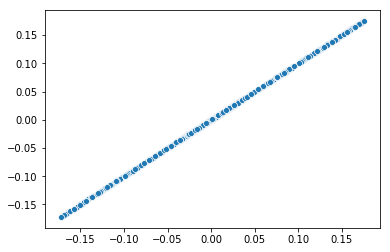

In [67]:
weights_pruned_untrained  = get_weights(model_plot)
print('ACCURACY: {}%'.format(test(model_plot, testloader).numpy()))
sns.scatterplot(weights_original[0]+weights_original[1], weights_pruned_untrained[0] + weights_pruned_untrained[1] )

In [68]:
## prune before training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_plot.parameters(), lr=params['learning_rate'])
train(model_plot, trainloader, criterion, optimizer, n_epochs = params['num_epochs'])

    --> EPOCH 0, ITER 0, LOSS 2.324638843536377
    --> EPOCH 0, ITER 2000, LOSS 0.4379372000694275
    --> EPOCH 1, ITER 0, LOSS 0.09845754504203796
    --> EPOCH 1, ITER 2000, LOSS 0.056322336196899414
    --> EPOCH 2, ITER 0, LOSS 0.06611917912960052
    --> EPOCH 2, ITER 2000, LOSS 0.21659734845161438
    --> EPOCH 3, ITER 0, LOSS 0.026007622480392456
    --> EPOCH 3, ITER 2000, LOSS 0.1552428901195526


ACCURACY: 93%


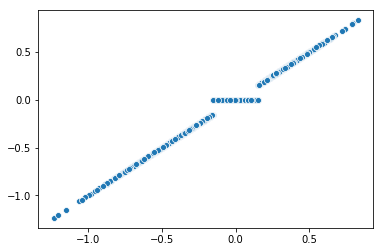

In [69]:
## Prune the model and train
weights_original  = get_weights(model_plot)
model_plot, mask_weights_pruned, mask_sign_pruned = prune_model(model_plot, 70)
weights_pruned_trained = get_weights(model_plot)
print('ACCURACY: {}%'.format(test(model_plot, testloader).numpy()))
sns.scatterplot(weights_original[0]+weights_original[1], weights_pruned_trained[0] + weights_pruned_trained[1] )

In [70]:
## Apply Masks on New Model
new_model = MLP_weight_prunning(INPUT_SIZE, HIDDEN_SIZE, NUM_LABELS)
print('ACCURACY: {}%'.format(test(new_model, testloader).numpy()))

ACCURACY: 13%


In [71]:
## Apply Weight and Sign Mask
new_model.set_masks(mask_weights_pruned)
new_model.set_signs(mask_sign_pruned)
print('ACCURACY: {}%'.format(test(new_model, testloader).numpy()))

ACCURACY: 52%


### Train w/ Several Prune Rates

In [ ]:
percentile_prune = [10, 20, 30, 50, 70, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
models_pruned = [prune_model(MLP_weight_prunning(INPUT_SIZE, HIDDEN_SIZE, NUM_LABELS), i) for i in percentile_prune]
optimizer = [optim.Adam(models_pruned[i].parameters(),lr=params['learning_rate']) for i in range(len(percentile_prune))]
losses = [nn.CrossEntropyLoss() for i in range(len(percentile_prune))]

In [ ]:
accuracy_prune = []
for i, (model, opt, loss) in enumerate(zip(models_pruned, optimizer, losses)):
    print("Traning Prune {} %".format(percentile_prune[i]))
    train(model, trainloader, loss, opt, n_epochs = params['num_epochs'])
    accuracy = test(model, testloader).numpy()
    accuracy_prune.append(float(accuracy))
    print('    --> TEST ACCURACY: {}%'.format(accuracy))
    print('-'*50)

In [ ]:
%matplotlib inline 
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
plt.subplots(figsize=(18, 6))
ax = sns.lineplot(percentile_prune, accuracy_prune)
ax.set(xlabel='Prune %', ylabel='Test Accuracy %')

In [ ]:
for mod in models_pruned:
    print(count_zeros_percentage(mod.linear1.weight.data.numpy()),count_zeros_percentage(mod.linear2.weight.data.numpy()))
    print('ACCURACY: {}%'.format(test(mod, testloader).numpy()))

## Other Mask Methods

## References
[1] https://github.com/zepx/pytorch-weight-prune/blob/develop/weight_pruning.py